In [1]:
import random 
import math

import numba
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from madigan.environments import make_env
from madigan.environments.cpp import Broker, Synth, Env as EnvC
from madigan.environments.cpp import Assets, RiskInfo, EnvInfoMulti, EnvInfoSingle

from madigan.fleet import make_agent

from madigan.utils.preprocessor import make_preprocessor as _make_preprocessor
from madigan.utils import make_config, State
from madigan.utils import ReplayBuffer, SARSD, DiscreteActionSpace
from madigan.utils import list_2_dict, reduce_train_metrics


from madigan.run.test import test
from madigan.utils.plotting import plot_test_metrics

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
config = make_config(
        experiment_id="SineCompositeQ",
        basepath="/media/hemu/Data/madigan/experiments",
        transaction_cost_rel=0.02,
    
        test_steps=1_000,
        nsteps=1_000_000,
    
        assets=["sine1"],
        data_source_type="SineAdder",
        data_source_config={
            'freq':[2.2, 4.1, 1., 3.],
            'mu':[.6, 0.3, 2., 4.2],
            'amp':[.5, 0.2, 0.4, 1.2],
            'phase':[0., 1., 4., 0.],
            'dX':0.01,
            "noise": 0.0},

        preprocessor_type="WindowedStacker",
#         window_length=64,
    
        agent_type = "DQN",
        discrete_actions=True,
        discrete_action_atoms=3,
        double_dqn=True,
        dueling=True,
        iqn=True,
        nTau1=32,
        nTau2=8,
        k_huber=1,
        nstep_return = 5,
        tau_soft_update=1e-4,
        replay_size=100_000,
        replay_min_size=50_000,
        batch_size=34,
        discount = 0.999,
        lot_unit_value=10_000,
    
        expl_eps_decay=0.999999,
    
        model_class="ConvNet",
        d_model = 1024,
        lr=1e-3,

    )

In [49]:
config = make_config(
        experiment_id="IQN_OU_trans_0.02_unit_0.05_RollerDiscrete_no_grad_clip_2",
        basepath="/media/hemu/Data/madigan/experiments",
    
        transaction_cost_rel=0.02,
    
        test_steps=1_000,
        nsteps=1_000_000,
    
#         data_source_type="Triangle",
#         generator_params={
#         'freq':[2.],
#         'mu':[0.6],
#         'amp':[.5],
#         'phase':[0.],
#         'dX':0.1,
#         "noise": 0.0},
#         assets=["sine1"],
#         data_source_type="SineAdder",
#         data_source_config={
#             'freq':[2.2, 4.1, 1., 3.],
#             'mu':[.6, 0.3, 2., 4.2],
#             'amp':[.5, 0.2, 0.4, 1.2],
#             'phase':[0., 1., 4., 0.],
#             'dX':0.01,
#             "noise": 0.0},
#         assets=["OU1"],
#         data_source_type="OU",
#         data_source_config=dict(
#             mean=[10.],
#             theta=[.15],
#             phi = [4.],
#             noise_var = [.1]
#         ),
    
        assets=["trend1"],
        data_source_type="SimpleTrend",
        data_source_config=dict(
            trend_prob=[.01],
            min_period=[500],
            max_period=[1500],
            noise = [.01],
            dY = [0.001],
            start = [5.0]),
        preprocessor_type="RollerDiscrete",
        preprocessor_config=dict(
            timeframes = [64],
            window_length = 64,
        ),
    
        agent_type = "DQN",
        discrete_actions=True,
        discrete_action_atoms=3,
        double_dqn=True,
        dueling=True,
        iqn=True,
        nTau1=32,
        nTau2=8,
        k_huber=1,
        nstep_return = 5,
        tau_soft_update=1e-4,
        replay_size=100_000,
        replay_min_size=50_000,
        batch_size=64,
        discount = 0.999,
        lot_unit_value=10_000,
        unit_size_proportion_avM=0.05,
    
        expl_eps_decay=0.999999,
    
        model_class="ConvNet",
        d_model = 1024,
        lr=1e-4,

    )
config

{'basepath': '/media/hemu/Data/madigan/experiments',
 'experiment_id': 'IQN_OU_trans_0.02_unit_0.05_RollerDiscrete_no_grad_clip_2',
 'parent_id': '',
 'transaction_cost_abs': 0.0,
 'transaction_cost_rel': 0.02,
 'slippage_abs': 0.0,
 'slippage_rel': 0.0,
 'env_type': 'Synth',
 'init_cash': 1000000,
 'required_margin': 1.0,
 'maintenance_margin': 0.25,
 'assets': ['trend1'],
 'lot_unit_value': 10000,
 'n_assets': 1,
 'discrete_actions': True,
 'discrete_action_atoms': 3,
 'data_source_type': 'SimpleTrend',
 'data_source_config': {'trend_prob': [0.01],
  'min_period': [500],
  'max_period': [1500],
  'noise': [0.01],
  'dY': [0.001],
  'start': [5.0]},
 'preprocessor_type': 'RollerDiscrete',
 'preprocessor_config': {'timeframes': [64], 'window_length': 64},
 'agent_type': 'DQN',
 'agent_config': {'type': 'DQN',
  'nsteps': 1000000,
  'replay_size': 100000,
  'episode_length': 1024,
  'replay_min_size': 50000,
  'train_freq': 4,
  'target_update_freq': 32000,
  'batch_size': 64,
  'discre

## Env

In [50]:
@numba.njit
def ternarize_array(arr):
    out = np.empty_like(arr)
    out[arr<0.] = -1.
    out[arr==0.] = 0.
    out[arr>0.] = 1.
    return out
# test
ara = np.random.randn(10)
out = ternarize_array(ara)
ara, out

(array([ 0.09307128,  0.90825361, -0.86296759, -1.45248052, -0.0063731 ,
        -0.02904985,  0.58726648,  0.2854593 ,  1.11086354, -1.35651988]),
 array([ 1.,  1., -1., -1., -1., -1.,  1.,  1.,  1., -1.]))

In [51]:
# @numba.vectorize([numba.int32(numba.int32),
#                   numba.int64(numba.int64),
#                   numba.float32(numba.float32),
#                   numba.float64(numba.float64)])

@numba.vectorize([numba.float32(numba.float32),
                  numba.float64(numba.float64)])
def ternarize_array(val):
    if val < 0:
        out = -1.
    elif val > 0.:
        out = 1.
    else:
        out = 0.
    return out
# test
ara = np.random.randn(10, 1)
out = ternarize_array(ara)
ara, out

(array([[ 0.14518025],
        [ 1.82750068],
        [ 1.51503859],
        [ 1.07758122],
        [-2.44122266],
        [ 0.88791275],
        [-0.18826484],
        [-0.09961584],
        [ 0.34761238],
        [ 1.0672781 ]]),
 array([[ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.]]))

In [52]:
from dataclasses import dataclass

@dataclass
class BrokerResponse:
    event: str
    timestamp: int
    transPrice: float
    transUnits: float
    transCost: float
    riskInfo: object
    marginCall: bool

@dataclass
class EnvInfo:
    brokerResponse: BrokerResponse
    exiting: bool
        

In [53]:
class EnvTernary(EnvC):
    def step(self, actions: np.ndarray = None):
        """
        If actions is None, no transaction is attempted and dataSource is iterated to
        get new prices
        If actions is passed, a transaction/s is attempted. Can only Reverse Positions, not add to 
        or close.
        Hence EnvBinary.
        """

        if actions is None: # no transaction
            prevEq = self.portfolio.equity
            newPrices = self.dataSource.getData()
            newEq = self.portfolio.equity
            reward = (newEq-prevEq) / prevEq
            risk = self.portfolio.checkRisk()
            done = False if risk == RiskInfo.green else True

            return (State(newPrices, np.array(self.ledgerNormed, copy=True),
                          self.dataSource.currentTime),
                    reward, done, EnvInfo(BrokerResponse("", 0, 0., 0., 0., 
                                                             risk, done), False))
        else:
            if not isinstance(actions, np.ndarray):
                raise TypeError("action must be an np array")

            prevEq = self.portfolio.equity
            newPrices = self.dataSource.getData()
            newEq = self.portfolio.equity
            reward = newEq / prevEq 
            reward = math.log(max(reward, 0.3))

            ledger_ternary = self.ledgerTernary
            actions_ternary = actions - 1
#             actions_ternary[ledger_ternary == actions_ternary] = 0.
            units = (0.2*self.availableMargin) / self.currentPrices
            transactions = actions_ternary * units

#             exiting = False
            assets = np.where(transactions!=0.)[0]
            for i, asset in enumerate(assets): # implicit if len(assets)
                reward -= self.transaction_cost_rel
#                 if self.ledger[i] != 0:
#                     exiting = True
#                     self.broker.close(int(asset))
                    
            broker_response_multi = self.broker.handleTransaction(transactions)
            
            done = False
            if broker_response_multi.marginCall:
                done=True
            for _risk in broker_response_multi.riskInfo:
                if _risk != RiskInfo.green:
                    done = True
#             if exiting:
#                 done = True
            if self.equity < 0.1 * self.portfolio.initCash:
                done = True
                print('equity: ', self.equity)

            return (State(newPrices, np.array(self.ledgerNormed, copy=True),
                          self.dataSource.currentTime),
                    reward, done, EnvInfo(broker_response_multi, 0.))

    @property
    def ledgerTernary(self):
        ara = np.array(self.ledger, copy=True)
        return ternarize_array(ara)
    

In [54]:
# def make_env(config):
#     assets = Assets(config.assets)
#     env = EnvTernary(config.data_source_type, assets, config.init_cash, config)
#     env.lot_unit = config.lot_unit_value
#     env.action_atoms = config.discrete_action_atoms
#     env.transaction_cost_rel = config.transaction_cost_rel
# #     env.setTransactionCost
#     return env

In [55]:
env = make_env(config)
srdi = env.step(np.array([10000]))
print('reward:', srdi[1])
print('reward:', env.step()[1])
env.step(np.array([0]))
env.reset()
print(env.currentPrices, env.cash, env.equity, env.ledger, env.availableMargin)

reward: 0.0
reward: -3.8480639079160554e-05
[5.00812939] 1000000.0 1000000.0 [0.] 1000000.0


In [56]:
srdi[3].brokerResponse.transactionCost

array([999.40658806])

In [57]:
from rollers import Roller
from madigan.utils.preprocessor import RollerDiscrete
roller = Roller(timeframes=[64])

In [58]:
out = []
for i in range(64):
    env.step()
    out.append(roller.roll(env.currentPrices))
    

In [59]:
rolled = np.concatenate([o[:, :, 0] for o in out], axis=0)
rolled.shape 

(64, 8)

In [60]:
from collections import deque
import sklearn.preprocessing

class Preprocessor:
    def __init__(self, window_len):
        self.k = window_len
        self.min_tf = self.k
        self.price_buffer = deque(maxlen=self.k)
        self.portfolio_buffer = deque(maxlen=self.k)
        self.time_buffer = deque(maxlen=self.k)
        self.feature_output_size = 12

    def __len__(self):
        return len(self.price_buffer)

    def stream_srdi(self, srdi):
        self.price_buffer.append(srdi[0].price)
        self.portfolio_buffer.append(srdi[0].portfolio)
        self.time_buffer.append(srdi[0].timestamp)

    def stream_state(self, state):
        self.price_buffer.append(np.array(state.price, copy=True))
        self.portfolio_buffer.append(np.array(state.portfolio, copy=True))
        self.time_buffer.append(np.array(state.timestamp, copy=True))

    def stream(self, data):
        if isinstance(data, tuple): # assume srdi
            self.stream_srdi(data)
        elif isinstance(data, (StateA, State)):
            self.stream_state(data)

    def current_data(self):
        prices = np.array(self.price_buffer, copy=True)
        prices = sklearn.preprocessing.minmax_scale(prices)
        features = np.empty(self.feature_output_size)
        for i, window in enumerate([3, 5, 7, 11]):
            features[i] = np.mean(prices[-window:])
            features[i+4] = np.var(prices[-window:])
        features[8] = prices.min()
        features[9] = prices.max()
        features[10] = prices[0]
        features[11] = prices[-1]
        return State(features.reshape(-1, 1) ,
                     self.portfolio_buffer[-1],
                     self.time_buffer[-1])

    def initialize_history(self, env):
        while len(self) < self.k:
            _state, reward, done, info = env.step()
            self.stream_state(_state)

from rollers import Roller as _Roller
class RollerDiscrete:
    """
    Wraps Roller to accumulate rolling window features
    using discrete windows
    Single Price Series.
    """
    def __init__(self, timeframes: list, window_len=64):
        self.timeframes = timeframes
        self.k = window_len
        self._roller = _Roller(timeframes)
        self.min_tf = max(self._roller.timeframes_uint64_t)
        self.price_buffer = deque(maxlen=self.k)
        self.feature_buffer = deque(maxlen=self.k)
        self.portfolio_buffer = deque(maxlen=self.k)
        self.time_buffer = deque(maxlen=self.k)
        self.feature_output_size = 8*len(self.timeframes)

    def __len__(self):
        return len(self.price_buffer)

    def stream_srdi(self, srdi):
        self.stream_state(srdi[0])

    def stream_state(self, state):
        self.price_buffer.append(state.price)
        self.portfolio_buffer.append(state.portfolio)
        self.time_buffer.append(state.timestamp)
        feats = np.nan_to_num(self._roller.roll(state.price, 
                                               np.array([state.timestamp]))
                             )
        self.feature_buffer.append(feats)

    def stream(self, data):
        if isinstance(data, tuple): # assume srdi
            self.stream_srdi(data)
        elif isinstance(data, (StateA, State)):
            self.stream_state(data)

    def current_data(self):
        current_len = len(self.price_buffer)
        prices = np.array(self.price_buffer, copy=True)
        current_price = prices[-1, 0]
        feats = np.concatenate(self.feature_buffer, axis=0)
        feats[:, :4, :] /= current_price
        prices /= current_price
        feats = feats.reshape(current_len,-1)
        feats = np.concatenate([prices, feats], axis=1)
        return State(feats,
                     self.portfolio_buffer[-1],
                     self.time_buffer[-1])

    def initialize_history(self, env):
        while len(self) < self.k:
            _state, reward, done, info = env.step()
            self.stream_state(_state)

In [61]:
preproc = RollerDiscrete(timeframes=[64], window_len=64)
preproc.initialize_history(env)
preproc.current_data().price.shape

(64, 9)

In [62]:
def make_preprocessor(config):
    if config.preprocessor_type == "Custom":
        return Preprocessor(config.preprocessor_config.window_length)
#     if config.preprocessor_type == "RollerDiscrete":
#         return RollerDiscrete(config.preprocessor_config.timeframes, config.preprocessor_config.window_length)
    return _make_preprocessor(config)

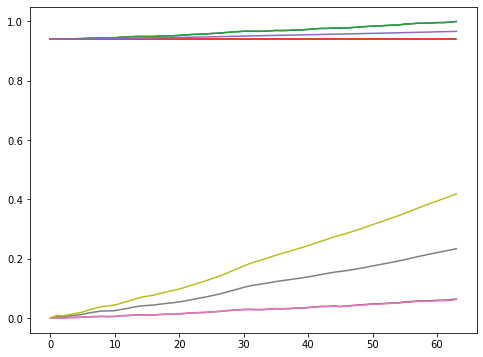

In [80]:
from IPython.core.pylabtools import figsize
figsize(8, 6)

preprocessor = make_preprocessor(config)
env.currentPrices
preprocessor.initialize_history(env)
current_data = preprocessor.current_data().price
plt.plot(current_data[:, :])
# env.reset()

In [81]:
np.argmax(current_data.mean(axis=0))
current_data[:, 7]
# current_data[:, 0]

array([0.        , 0.00609882, 0.00436468, 0.00753496, 0.00945586,
       0.01221455, 0.01732568, 0.0205558 , 0.02362294, 0.02387811,
       0.02460336, 0.02891818, 0.03246197, 0.03706983, 0.04064348,
       0.04213578, 0.04345907, 0.04645455, 0.04915929, 0.05123904,
       0.05411951, 0.05780494, 0.06227256, 0.06652329, 0.07029905,
       0.07501083, 0.07970231, 0.08511373, 0.0911936 , 0.09719116,
       0.10326335, 0.1083945 , 0.11217243, 0.11542192, 0.11897027,
       0.1229161 , 0.12593785, 0.12895762, 0.1321613 , 0.13513542,
       0.13856369, 0.14243428, 0.14661448, 0.15034692, 0.15425382,
       0.15695135, 0.15989578, 0.16340554, 0.16714086, 0.17116806,
       0.17548819, 0.17946704, 0.18364273, 0.18788852, 0.1918738 ,
       0.1968289 , 0.20164878, 0.20681397, 0.21145284, 0.21584565,
       0.22038548, 0.22458791, 0.22885013, 0.23363146])

## Agent

In [82]:
import torch.nn.functional as F
from madigan.utils import DiscreteRangeSpace, DiscreteActionSpace

class AgentLM:
    def __init__(self, config, feature_input_shape, env, device=None):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self._env = env
        
        self.action_atoms = config.discrete_action_atoms
        self.lot_unit_value = config.lot_unit_value
        self.unit_size = config.agent_config.unit_size_proportion_avM
        actions = [self.lot_unit_value*action - self.action_atoms//2 for action in range(self.action_atoms)]
        probs = [1/len(actions) for i in actions]
#         self._action_space = DiscreteActionSpace(actions, probs, len(config.assets))
#         self._action_space = DiscreteRangeSpace((0, 2), len(config.assets))
#         input_size = config.preprocessor_config.window_length + len(config.assets)
        feature_input_size = feature_input_shape[0]
        input_size = feature_input_size + len(config.assets)
        self.model_b = nn.Linear(input_size, self.action_atoms).to(device).float()
        self.model_t = nn.Linear(input_size, self.action_atoms).to(device).float()
        
        self.dueling = config.model_config.dueling
        self.double_dqn = config.agent_config.double_dqn
        self.discount = config.agent_config.discount
        self.nstep_return = config.agent_config.nstep_return
        
        self.opt = torch.optim.Adam(self.model_b.parameters(), lr=config.optim_config.lr)
        
        self.tau_soft_update = config.agent_config.tau_soft_update
        self.config = config
        
    @property
    def env(self):
        return self._env
    
    @property
    def action_space(self):
        units = self.unit_size * self.env.availableMargin / self.env.currentPrices
        units *= np.array([-1., 0., 1.])
        return DiscreteActionSpace(units, probs=[])
        actions = np.random.choice([-1., 0., 1.], len(units))
        actions *= units
        return self._action_space
    
    def prep_state(self, x):
        price = x.price[None, ..., 0]
        x = np.concatenate([price, x.portfolio[None, ...]], axis=-1)
        return torch.from_numpy(x).float().to(self.device)
    
    def get_qvals(self, x, target=False):
        x = self.prep_state(x)
        if target:
            qvals = self.model_t(x)
        else:
            qvals = self.model_b(x)
        return qvals.detach()
    
    def action_to_transaction(self, actions):
        units = self.unit_size * self.env.availableMargin / self.env.currentPrices
        actions_ternary = (actions - (self.action_atoms // 2)).cpu().numpy()
        return units * actions_ternary
        
    @torch.no_grad()
    def __call__(self, x, target=False):
        qvals = self.get_qvals(x, target=target)
        actions = qvals.max(-1)[1]
        return self.action_to_transaction(actions)
        
    def prep_sarsd(self, sarsd):
        state = State(
            price = torch.as_tensor(sarsd.state.price[..., 0], 
                                    dtype=torch.float32).to(self.device),
            portfolio = torch.as_tensor(sarsd.state.portfolio, 
                                        dtype=torch.float32).to(self.device),
            timestamp = sarsd.state.timestamp
        )
#         action = np.rint(sarsd.action // self.lot_unit_value) + self.action_atoms//2
        action = ternarize_array(sarsd.action) + self.action_atoms // 2
        action = torch.as_tensor(action, dtype=torch.long, device=self.device)[..., 0]
        reward = torch.as_tensor(sarsd.reward, dtype=torch.float32, device=self.device)
        next_state = State(
            price = torch.as_tensor(sarsd.next_state.price[..., 0], 
                                    dtype=torch.float32, device=self.device),
            portfolio = torch.as_tensor(sarsd.next_state.portfolio, 
                                        dtype=torch.float32, device=self.device),
            timestamp = sarsd.next_state.timestamp
        )
        done = torch.as_tensor(sarsd.done, dtype=torch.bool, device=self.device)
        state = torch.cat([state.price, state.portfolio], dim=-1)
        next_state = torch.cat([next_state.price, next_state.portfolio], dim=-1)
        return state, action, reward, next_state, done
    
    def loss_fn(self, Qt, Gt):
        return F.smooth_l1_loss(Qt, Gt)
    
    @torch.no_grad()
    def get_Gt(self, reward, next_state, done):
        if self.double_dqn:
            behaviour_actions = self.model_b(next_state).max(-1)[1]
            one_hot = F.one_hot(behaviour_actions, self.action_atoms).to(self.device)
            greedy_qvals_next = (self.model_t(next_state)*one_hot).sum(-1)
        else:
            greedy_qvals_next = self.model_t(next_state).max(-1)[0]
        Gt = reward[:, None] + (~done[:, None] * (self.discount**self.nstep_return) * greedy_qvals_next)
        return Gt
            
    def train_step(self, sarsd):
        state, action, reward, next_state, done = self.prep_sarsd(sarsd)
        self.opt.zero_grad()
        action_mask = F.one_hot(action, self.action_atoms).to(self.device)
        qvals = self.model_b(state)
        assert qvals.shape[1:] == (len(self.config.assets), self.action_atoms)
        Qt = (qvals*action_mask).sum(-1)
        assert Qt.shape[1:] == (len(self.config.assets), )
        Gt = self.get_Gt(reward, next_state, done)
        assert Qt.shape == Gt.shape
        
        loss = self.loss_fn(Qt, Gt)
        loss.backward()
        self.opt.step()
        
        td_error = (Gt-Qt).abs().mean().detach().item()
        
        self.update_target()
        
        return {'loss': loss.detach().item(), 'td_error': td_error, 'Qt': Qt.detach(), 'Gt': Gt.detach()}
    
    def update_target(self):
        """
        Soft Update 
        """
        for behaviour, target in zip(self.model_b.parameters(), self.model_t.parameters()):
            target.data.copy_(self.tau_soft_update * behaviour.data + \
                              (1.-self.tau_soft_update)*target.data)
#         self.model_t.load_state_dict(self.model_b.state_dict())
        

In [83]:
class AgentMLP(AgentLM):
    def __init__(self, config, feature_input_shape, env, device=None):
        super().__init__(config, feature_input_shape, env, device)
        d_model = config.model_config.d_model
        input_size = feature_input_shape[0] + len(config.assets)
        self.model_b = nn.Sequential(nn.Linear(input_size, d_model), nn.ReLU(), 
                                     nn.Linear(d_model, self.action_atoms)).to(device).float()
        self.model_t = nn.Sequential(nn.Linear(input_size, d_model), nn.ReLU(), 
                                     nn.Linear(d_model, self.action_atoms)).to(device).float()        
        self.opt = torch.optim.Adam(self.model_b.parameters(), lr=config.optim_config.lr)


In [84]:
from madigan.utils import calc_conv_out_shape
from madigan.fleet.net.conv_net import ConvNet

class DuelingHead(nn.Module):
    """
    Replace normal output layer in DQN with this for Dueling Network Architectures
    See: https://arxiv.org/pdf/1511.06581.pdf
    """

    def __init__(self, d_in, d_out):
        super().__init__()
        self.value_net = nn.Linear(d_in, 1)
        self.adv_net = nn.Linear(d_in, d_out)
    def forward(self, x):
        value = self.value_net(x)
        adv = self.adv_net(x)
        qvals = value + adv - adv.mean(-1, keepdim=True)
        return qvals
    
class _ConvModel(nn.Module):
    def __init__(self, config, feature_input_shape):
        super().__init__()
        nassets = len(config.assets)
        d_model = config.model_config.d_model
        nactions = config.discrete_action_atoms
        self.conv1 = nn.Conv1d(1, 32, 5)
        self.conv2 = nn.Conv1d(32, 32, 5)
        out_shape = calc_conv_out_shape(feature_input_shape[0], [self.conv1, self.conv2])
        self.fc1 = nn.Linear(nassets+out_shape[0]*32, d_model)
        if config.model_config.dueling:
            self.output_head = DuelingHead(d_model, nactions)
        else:
            self.output_head = nn.Linear(d_model, nactions)
        self.act = nn.GELU()     
        
    def forward(self, state):
        price = state.price.transpose(-1, -2)
        portfolio = state.portfolio
        price_emb = self.act(self.conv1(price))
        price_emb = self.act(self.conv2(price_emb)).view(price.shape[0], -1)

        full_emb = torch.cat([price_emb, portfolio], dim=-1)
        out = self.act(self.fc1(full_emb))

        out = self.output_head(out)
        return out
        
class AgentCNN(AgentLM):
    def __init__(self, config, feature_input_shape, env, device=None):
        super().__init__(config, feature_input_shape, env, device)
#         self.model_b = ConvModel(config, feature_input_shape).to(device).float()
#         self.model_t = ConvModel(config, feature_input_shape).to(device).float()
        n_assets = len(config.assets)
        n_actions = config.discrete_action_atoms
        self.model_b = ConvNet(feature_input_shape, (n_assets, n_actions),
                              d_model=config.model_config.d_model,
                              dueling=True, preserve_window_len=False).to(device).float()
        self.model_t = ConvNet(feature_input_shape, (n_assets, n_actions),
                              d_model=config.model_config.d_model,
                              dueling=True, preserve_window_len=False).to(device).float()

        self.opt = torch.optim.Adam(self.model_b.parameters(), lr=config.optim_config.lr)
        
    def prep_state(self, state, batch=False):
        if not batch:
            price = torch.as_tensor(state.price[None, ...], dtype=torch.float32).to(self.device)
            port = torch.as_tensor(state.portfolio[None, -1], dtype=torch.float32).to(self.device)
        else:
            price = torch.as_tensor(state.price, dtype=torch.float32).to(self.device)
            port = torch.as_tensor(state.portfolio[:, -1], dtype=torch.float32).to(self.device)
#         timestamp = torch.as_tensor(state.timestamp)
        return State(price, port, state.timestamp)

    def prep_sarsd(self, sarsd):
        state = self.prep_state(sarsd.state, batch=True)
#         action = np.rint(sarsd.action // self.lot_unit_value) + self.action_atoms//2
        action = ternarize_array(sarsd.action) + self.action_atoms // 2
        action = torch.as_tensor(action, dtype=torch.long, device=self.device)[..., 0]
        reward = torch.as_tensor(sarsd.reward, dtype=torch.float32, device=self.device)
        next_state = self.prep_state(sarsd.next_state, batch=True)
        done = torch.as_tensor(sarsd.done, dtype=torch.bool, device=self.device)
        return state, action, reward, next_state, done

In [85]:
class DuelingHeadIQN(nn.Module):
    """
    Replace normal output layer in DQN with this for Dueling Network Architectures
    See: https://arxiv.org/pdf/1511.06581.pdf
    """

    def __init__(self, d_in, d_out):
        super().__init__()
        self.value_net = nn.Linear(d_in, 1)
        self.adv_net = nn.Linear(d_in, d_out)
    def forward(self, x):
        value = self.value_net(x)
        adv = self.adv_net(x)
        qvals = value + adv - adv.mean(-1, keepdim=True)
        return qvals
    
class TauEmbedLayer(nn.Module):
    """
    For use in distributional DQN approach I.e IQN, FQF
    """
    def __init__(self, d_embed, d_model):
        super().__init__()
        self.d_embed = d_embed
        self.projection = nn.Linear(d_embed, d_model)
        self.act = nn.GELU()
        self.spectrum_range = math.pi* torch.arange(1, self.d_embed+1, 
                                           dtype=torch.float).view(1, 1, self.d_embed)
        
    def forward(self, tau):
        # embed using cos - like transformers
        spectrum = tau[:, :, None] * self.spectrum_range.to(tau.device)
        basis = torch.cos(spectrum)
        embedded = self.act(self.projection(basis))
        return embedded
    
    
class ConvModelIQN(nn.Module):
    def __init__(self, config, feature_input_shape):
        super().__init__()
        nassets = len(config.assets)
        d_model = config.model_config.d_model
        tau_embed_size = config.agent_config.tau_embed_size
        nactions = config.discrete_action_atoms
        self.nTau = config.agent_config.nTau1
        self.conv1 = nn.Conv1d(1, 32, 5)
        self.conv2 = nn.Conv1d(32, 32, 5)
        self.tau_embed_layer = TauEmbedLayer(tau_embed_size, d_model)
        out_shape = calc_conv_out_shape(feature_input_shape[0], [self.conv1, self.conv2])
        self.fc1 = nn.Linear(nassets+out_shape[0]*32, d_model)
        if config.model_config.dueling:
            self.output_head = DuelingHeadIQN(d_model, nactions)
        else:
            self.output_head = nn.Linear(d_model, nactions)
        self.act = nn.GELU()     
        
    def forward(self, state, tau=None):
        
        price = state.price.transpose(-1, -2)
        portfolio = state.portfolio
        price_emb = self.act(self.conv1(price))
        price_emb = self.act(self.conv2(price_emb)).view(price.shape[0], -1)

        state_emb = torch.cat([price_emb, portfolio], dim=-1)
        state_emb = self.act(self.fc1(state_emb))
        if tau is None:
            tau = torch.rand(state.price.shape[0], self.nTau,
                            dtype=torch.float, device=state.price.device)
        tau_emb = self.tau_embed_layer(tau)
        full_emb = state_emb.unsqueeze(1) * tau_emb # (bs, nTau, d_model)
        quantiles = self.output_head(full_emb) # (bs, nTau, n_actions)
        return quantiles

from madigan.fleet.net.conv_net_iqn import ConvNetIQN

class AgentCNN_IQN(AgentLM):
    def __init__(self, config, feature_input_shape, env, device=None):
        super().__init__(config, feature_input_shape, env, device)
        self.n_assets = len(config.assets)
        self.n_actions = config.discrete_action_atoms
        self.model_b = ConvNetIQN(feature_input_shape, (self.n_assets, self.n_actions),
                              d_model=config.model_config.d_model,
                              dueling=True, preserve_window_len=False,
                              tau_embed_size=config.model_config.tau_embed_size,
                              nTau=config.model_config.nTau).to(device).float()
        self.model_t = ConvNetIQN(feature_input_shape, (self.n_assets, self.n_actions),
                              d_model=config.model_config.d_model,
                              dueling=True, preserve_window_len=False,
                              tau_embed_size=config.model_config.tau_embed_size,
                              nTau=config.model_config.nTau).to(device).float()
        self.opt = torch.optim.Adam(self.model_b.parameters(), lr=config.optim_config.lr)
        self.nTau1 = config.agent_config.nTau1
        self.nTau2 = config.agent_config.nTau2
        self.k_huber = config.agent_config.k_huber
        self.risk_distortion = lambda x: x
        
    def prep_state(self, state, batch=False):
        if not batch:
            price = torch.as_tensor(state.price[None, ...], dtype=torch.float32).to(self.device)
            port = torch.as_tensor(state.portfolio[None, -1], dtype=torch.float32).to(self.device)
        else:
            price = torch.as_tensor(state.price, dtype=torch.float32).to(self.device)
            port = torch.as_tensor(state.portfolio[:, -1], dtype=torch.float32).to(self.device)
#         timestamp = torch.as_tensor(state.timestamp)

#         price[..., :4] = torch.log(price[..., :4])
        return State(price, port, state.timestamp)

    def prep_sarsd(self, sarsd):
        state = self.prep_state(sarsd.state, batch=True)
#         action = np.rint(sarsd.action // self.lot_unit_value) + self.action_atoms//2
        action = ternarize_array(sarsd.action) + self.action_atoms // 2
        action = torch.as_tensor(action, dtype=torch.long, device=self.device)[..., 0]
        reward = torch.as_tensor(sarsd.reward, dtype=torch.float32, device=self.device)
        next_state = self.prep_state(sarsd.next_state, batch=True)
        done = torch.as_tensor(sarsd.done, dtype=torch.bool, device=self.device)
        return state, action, reward, next_state, done
    
    def get_quantiles(self, x, target=False):
        x = self.prep_state(x)
        if target:
            quantiles = self.model_t(x)
        else:
            quantiles = self.model_b(x)
        return quantiles.detach()
    
    def get_qvals(self, x, target=False):
        quantiles = self.get_quantiles(x, target=target)   
        qvals = quantiles.mean(1)
        return qvals.detach()
        
    @torch.no_grad()
    def __call__(self, x, target=False):
        qvals = self.get_qvals(x, target=target)
        actions = qvals.max(-1)[1]
        return self.action_to_transaction(actions)
    
    def get_Gt(self, reward, done, next_state):
        with torch.no_grad():
            tau_greedy = torch.rand(next_state.price.shape[0], self.nTau1, 
                                    dtype=torch.float, device=next_state.price.device,
                                   requires_grad=False)
            tau_greedy = self.risk_distortion(tau_greedy)
            tau2 = torch.rand(next_state.price.shape[0], self.nTau2, 
                                dtype=torch.float, device=next_state.price.device,
                                 requires_grad=False)
            if self.double_dqn:
                greedy_quantiles = self.model_b(next_state, tau=tau_greedy) #(bs, nTau1, nactions)
            else:
                greedy_quantiles = self.model_t(next_state, tau=tau_greedy) #(bs, nTau1, nactions)
            greedy_actions = torch.argmax(greedy_quantiles.mean(1), dim=-1, keepdim=True) #(bs, 1)
            assert greedy_actions.shape[1:] == (self.n_assets, 1)
            one_hot_greedy = F.one_hot(greedy_actions, self.action_atoms).to(next_state.price.device)
            quantiles_next_full = self.model_t(next_state, tau=tau2) #(bs, nTau2, nactions)
            quantiles_next = (quantiles_next_full * one_hot_greedy).sum(-1) #(bs, nTau2)
            # Add dim to reward and done to broadcast opeartions with quantiles_next 
#             import ipdb; ipdb.set_trace()
            Gt = reward[:, None, None] + (~done[:, None, None] *\
                                          (self.discount**self.nstep_return) *\
                                          quantiles_next)
            return Gt
        
    def train_step(self, sarsd):
#         before_train = torch.cuda.memory_allocated()
        state, action, reward, next_state, done = self.prep_sarsd(sarsd)
        self.opt.zero_grad()
        
        tau1 = torch.rand(state.price.shape[0], self.nTau1, dtype=torch.float, 
                          device=state.price.device)
        quantiles = self.model_b(state, tau=tau1)
        
        action_mask = F.one_hot(action[:, None], self.action_atoms).to(self.device)
        
        Gt = self.get_Gt(reward, done, next_state)
        Qt = (quantiles*action_mask).sum(-1) #(bs, nTau1)
        loss, td_error = self.loss_fn(Qt, Gt, tau1)
        loss.backward()
        
#         nn.utils.clip_grad_norm_(self.model_b.parameters(), 0.5)
        self.opt.step()
        
        self.update_target()

        return {'loss': loss.detach().item(), 
                'td_error': td_error.detach().item(), 
#                 'Qt': Qt.detach(), 'Gt': Gt.detach()}
                'Qt': Qt.detach().mean().item(), 'Gt': Gt.detach().mean().item()}
    
    def loss_fn(self, Qt, Gt, tau):
        """
        Quantile Huber Loss
        td_error: (bs, nTau1, nTau2)
        """
        assert Qt.shape[1:] == (self.nTau1, self.n_assets)
        assert Gt.shape[1:] == (self.nTau2, self.n_assets)
        td_error = Gt.unsqueeze(1) - Qt.unsqueeze(-1)
        
        huber_loss = torch.where(td_error.abs() <= self.k_huber,
                                 0.5*td_error.pow(2),
                                 self.k_huber * (td_error.abs() - self.k_huber/2))
        
        assert huber_loss.shape == td_error.shape
        
        quantile_loss = torch.abs(tau[..., None, None] - (td_error.detach() < 0.).float()) * \
                        huber_loss  / self.k_huber
        assert quantile_loss.shape == huber_loss.shape
        
        return quantile_loss.mean(-1).sum(-1).mean(), td_error.abs().mean()
    

In [86]:
class PerfectAgent:
    """
    Pretty much useless
    Only implemented for sinewave and 2 action atoms (buy/sell)
    """
    def __init__(self, config):
        self.config=config
        self.action_atoms = config.discrete_action_atoms
        self.params = self.config.generator_params
        
    def get_qvals(self, state):
        prices = state.price
        if self.config.data_source_type in  ("Synth", "Triangle"):
            if prices[-3] < prices[-2] > prices[-1]:
                return torch.tensor([[-1., 1.]])
            elif prices[-3] > prices[-2] < prices[-1]:
                return torch.tensor([[1., -1.]])
            else:
                return torch.randn((1, 2))
        elif self.config.data_source_type == "SawTooth":
            _max = np.array(self.params['amp']) + np.array(self.params['mu'])
            if (_max - prices[-1] ) > (_max/1.25):
                return torch.tensor([[1., -1.]])
            return torch.tensor([[-1., 1.]])

    def __call__(self, state):
        qvals = self.get_qvals(state)
        if qvals[0, 1] > qvals[0, 0]:
            return np.array([1])
        return np.array([0])

In [87]:
print(preprocessor.feature_output_shape)

(64, 9)


In [88]:
from madigan.fleet import make_agent


agent = AgentLM(config, preprocessor.feature_output_shape, env, device=device)
agent = AgentMLP(config, preprocessor.feature_output_shape, env, device=device)
agent = AgentCNN(config, preprocessor.feature_output_shape, env, device=device)
agent = AgentCNN_IQN(config, preprocessor.feature_output_shape, env, device=device)
agent = make_agent(config)
agent.to(device)
x = preprocessor.current_data()
# x = agent.prep_state(x)
qvals = agent.get_qvals(x)

action = agent(x)
print(qvals, action)
env.step(action)

tensor([[[72579.3828, 83138.3984, 41510.1133]]], device='cuda:0') [0.]


(<madigan.environments.cpp.build.env.State at 0x7ff5c5d955f0>,
 0.0,
 False,
 <madigan.environments.cpp.build.env.EnvInfoMulti at 0x7ff5c5d47270>)

In [89]:
actions = qvals.max(-1)[1][:, 0]
actions


tensor([1], device='cuda:0')

## Trainer


In [90]:
def trainer(agent, env, preprocessor, config):
    nstep_return =config.agent_config.nstep_return
    rb = ReplayBuffer(config.agent_config.replay_size, nstep_return, 
                      config.agent_config.discount)
#     nstep_buffer = []
    replay_min_size = config.agent_config.replay_min_size
    action_shape = (len(config.assets), 1)
    eps = config.agent_config.eps
    eps_decay = config.agent_config.eps_decay
    eps_min = config.agent_config.eps_min
    env.reset()
    preprocessor.initialize_history(env)
    state = preprocessor.current_data()
    i = 0
    running_reward = 0.
    running_cost = 0.
    unit_size = config.agent_config.unit_size_proportion_avM
    while True:
        trn_metrics=None
        
        if random.random() < eps:
            units = unit_size * env.availableMargin / env.currentPrices
            actions = np.random.choice([-1., 0., 1.], action_shape)
            actions *= units
            # actions = agent.action_space.sample)()
        else:
            actions = agent(state, target=False)
        eps = max(eps_min, eps*eps_decay)
        
#         Prevent double positon
#         for i, action in enumerate(actions):
#             if np.sign(action) == np.sign(env.ledger):
#                 actions[i] = 0.

        _next_state, reward, done, info = env.step(actions) # assumes single asset
        for cost in info.brokerResponse.transactionCost:
            running_cost += cost
#         reward = max(-1., min(reward, 1.))
        preprocessor.stream_state(_next_state)
        next_state = preprocessor.current_data()
        if done:
            reward = -1.
        running_reward += reward
        sarsd = SARSD(state, actions, reward, next_state, done)
        rb.add(sarsd)
        
        if done:
            print('running_reward: ', '{:.3f}'.format(running_reward), 'running_cost: ', 
                  '{:1.0}'.format(running_cost), 'equity: ', env.equity ,
                  'margin call: ', info.brokerResponse.marginCall)
            env.reset()
            preprocessor.initialize_history(env)
            state = preprocessor.current_data()
            #print('done: ', info.brokerResponse, 'margin call: ', info.brokerResponse.marginCall,

            running_reward = 0.
            running_cost = 0.
        else:
            state = next_state
        if len(rb) >= replay_min_size:
            sarsd = rb.sample(config.agent_config.batch_size)
            trn_metrics = agent.train_step(sarsd)
            trn_metrics['eps'] = eps
            trn_metrics['running_reward'] = running_reward
            
            
#         if i % target_update_freq == 0:
#             agent.model_t.load_state_dict(agent.model_b.state_dict())
            
        yield trn_metrics
        i += 1

In [91]:
import gc
def print_tensors():
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                print(type(obj), obj.size())
        except:
            pass
        
def print_tau_tensors():
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                if obj.shape in ((34, 32) , (34, 8)):
                    print(type(obj), obj.size())
        except:
            pass
        
def print_scalar_tensors():
    num = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                if obj.shape == ():
                    print(type(obj), obj.size())
                    num += 1
        except:
            pass
    print('num', num)

In [92]:
config = make_config(
        experiment_id="IQN_OU_trans_0.02_log_feats",
        basepath="/media/hemu/Data/madigan/experiments",
    
        transaction_cost_rel=0.02,
    
        test_steps=1_000,
        nsteps=1_000_000,
    
#         data_source_type="Triangle",
#         generator_params={
#         'freq':[2.],
#         'mu':[0.6],
#         'amp':[.5],
#         'phase':[0.],
#         'dX':0.1,
#         "noise": 0.0},
#         assets=["sine1"],
#         data_source_type="SineAdder",
#         data_source_config={
#             'freq':[2.2, 4.1, 1., 3.],
#             'mu':[.6, 0.3, 2., 4.2],
#             'amp':[.5, 0.2, 0.4, 1.2],
#             'phase':[0., 1., 4., 0.],
#             'dX':0.01,
#             "noise": 0.0},
#         assets=["OU1"],
#         data_source_type="OU",
#         data_source_config=dict(
#             mean=[10.],
#             theta=[.15],
#             phi = [4.],
#             noise_var = [.1]
#         ),
    
        assets=["trend1"],
        data_source_type="SimpleTrend",
        data_source_config=dict(
            trend_prob=[.01],
            min_period=[500],
            max_period=[1500],
            noise = [.1],
            dY = [0.05],
            start = [5.0]),
        preprocessor_type="RollerDiscrete",
        preprocessor_config=dict(
            timeframes = [64, 256, 512],
            window_length = 64,
        ),
    
        agent_type = "IQN",
        discrete_actions=True,
        discrete_action_atoms=3,
        double_dqn=True,
        dueling=True,
        iqn=True,
        nTau1=32,
        nTau2=8,
        k_huber=1,
        nstep_return = 5,
        tau_soft_update=1e-4,
        replay_size=100_000,
        replay_min_size=50_000,
        batch_size=64,
        discount = 0.999,
        lot_unit_value=10_000,
        unit_size_proportion_avM=0.05,
    
        expl_eps_decay=0.999999,
    
        model_class="ConvNet",
        d_model = 1024,
        lr=1e-3,

    )
config

{'basepath': '/media/hemu/Data/madigan/experiments',
 'experiment_id': 'IQN_OU_trans_0.02_log_feats',
 'parent_id': '',
 'transaction_cost_abs': 0.0,
 'transaction_cost_rel': 0.02,
 'slippage_abs': 0.0,
 'slippage_rel': 0.0,
 'env_type': 'Synth',
 'init_cash': 1000000,
 'required_margin': 1.0,
 'maintenance_margin': 0.25,
 'assets': ['trend1'],
 'lot_unit_value': 10000,
 'n_assets': 1,
 'discrete_actions': True,
 'discrete_action_atoms': 3,
 'data_source_type': 'SimpleTrend',
 'data_source_config': {'trend_prob': [0.01],
  'min_period': [500],
  'max_period': [1500],
  'noise': [0.1],
  'dY': [0.05],
  'start': [5.0]},
 'preprocessor_type': 'RollerDiscrete',
 'preprocessor_config': {'timeframes': [64, 256, 512], 'window_length': 64},
 'agent_type': 'IQN',
 'agent_config': {'type': 'IQN',
  'nsteps': 1000000,
  'replay_size': 100000,
  'episode_length': 1024,
  'replay_min_size': 50000,
  'train_freq': 4,
  'target_update_freq': 32000,
  'batch_size': 64,
  'discrete_action_atoms': 3,
 

# Training

In [93]:
env = make_env(config)

# agent = make_agent(config)

preprocessor = make_preprocessor(config)
preprocessor.initialize_history(env)

agent = AgentCNN(config, preprocessor.feature_output_shape, env, device=device)
agent = AgentCNN_IQN(config, preprocessor.feature_output_shape, env, device=device)
# agent = make_agent(config)

In [94]:
# state_dict = torch.load('OU_IQN_behav.pth')['state_dict']
# agent.model_b.load_state_dict(state_dict)
# state_dict = torch.load('OU_IQN_target.pth')['state_dict']
# agent.model_t.load_state_dict(state_dict)

In [95]:
train_loop = iter(trainer(agent, env, preprocessor, config))
# INITIALIZE REPLAY BUFFER
print("Initializing replay buffer with min # of experiences")
for i in tqdm(range(config.agent_config.replay_min_size)):
    metrics = next(train_loop)
    
train_metrics=[]

Initializing replay buffer with min # of experiences


running_reward:  -2.550 running_cost:  3e+04 equity:  129651.27113010292 margin call:  True
running_reward:  -0.988 running_cost:  8e+04 equity:  223690.38732609898 margin call:  True
running_reward:  -0.945 running_cost:  7e+04 equity:  930373.3272649524 margin call:  True
running_reward:  -0.933 running_cost:  1e+05 equity:  591447.9671540805 margin call:  True
running_reward:  -2.201 running_cost:  7e+04 equity:  172565.62783385217 margin call:  True
running_reward:  -1.528 running_cost:  5e+04 equity:  545328.0661283334 margin call:  True
running_reward:  -0.343 running_cost:  2e+05 equity:  -850821.6469307411 margin call:  True
running_reward:  0.168 running_cost:  2e+05 equity:  1450275.1409044752 margin call:  True
running_reward:  -0.641 running_cost:  5e+04 equity:  18095.70137246605 margin call:  True
running_reward:  -0.536 running_cost:  1e+05 equity:  100881.05884482386 margin call:  True
running_reward:  -0.504 running_cost:  7e+04 equity:  1488134.6447844466 margin call:

In [96]:
agent.opt.lr = 1e-3

In [ ]:
iterations = 500_000
# train_loop = iter(trainer(agent, env, preprocessor, config))
env.reset()
for i in tqdm(range(iterations)):
    metrics = next(train_loop)
    if metrics is not None:
        train_metrics.append(metrics)
        
print('eps', metrics['eps'])

running_reward:  437.143 running_cost:  3e+05 equity:  70879.43399316166 margin call:  True
running_reward:  -1.783 running_cost:  2e+05 equity:  269047.09496255545 margin call:  True
running_reward:  0.378 running_cost:  3e+05 equity:  1050128.7262585638 margin call:  True


/home/hemu/miniconda3/envs/madigan/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


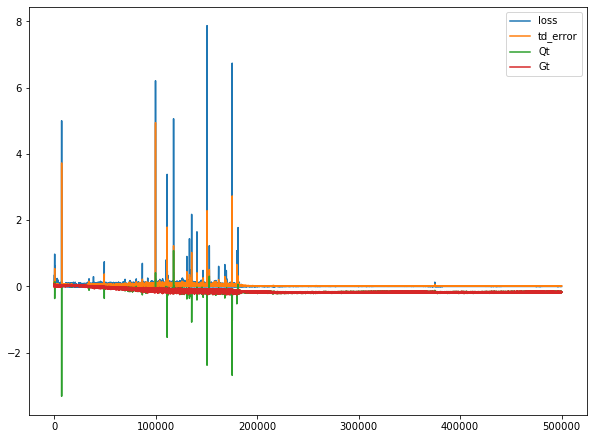

In [86]:
figsize(10, 7.5)
from madigan.utils.plotting import plot_train_metrics

trn_metrics = reduce_train_metrics(list_2_dict(train_metrics), ['Qt', 'Gt'])
# plt.plot(np.clip(trn_metrics['loss'], 0., 10.), label='loss')
# plt.plot(np.clip(trn_metrics['td_error'], 0., 10.), label='td_error')
plt.plot(trn_metrics['loss'], label='loss')
plt.plot(trn_metrics['td_error'], label='td_error')
plt.plot(trn_metrics['Qt'], label='Qt')
plt.plot(trn_metrics['Gt'], label='Gt')
plt.legend()
# plot_train_metrics(trn_metrics)

dict_keys(['state', 'reward', 'done', 'info', 'qvals', 'equity', 'prices', 'positions', 'cash', 'margin', 'transactions'])
plotting only first asset - need to implement multi-asset


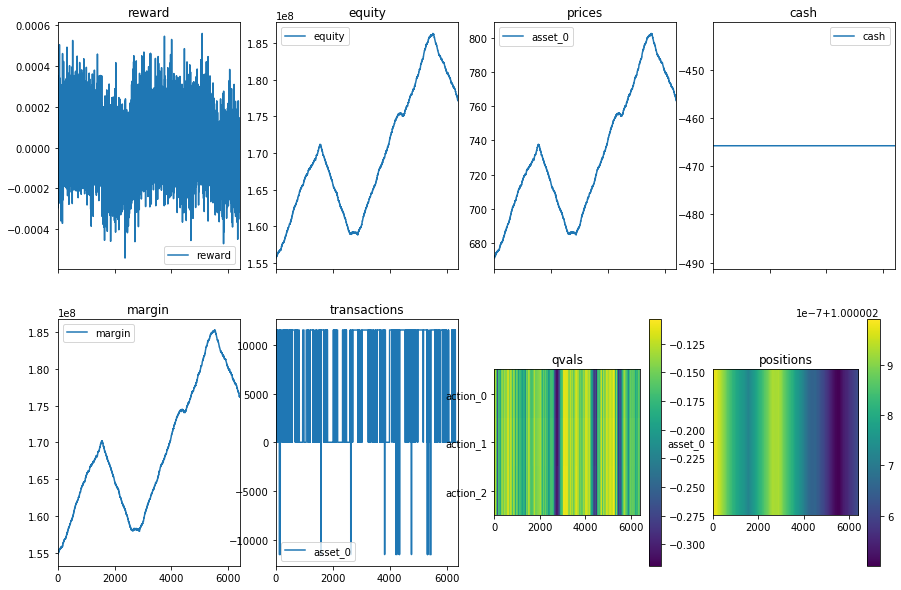

In [90]:
# from madigan.utils.plotting import plot_test_metrics
figsize(15, 10)
reset=True
reset=False

tst_metrics = test(agent, env, preprocessor, 
                   nsteps=6400, verbose=True, reset=reset, eps=0.)

print(tst_metrics.keys())

fig, ax = plot_test_metrics(tst_metrics)

In [36]:
state = {'state_dict': agent.model_b.state_dict(),
         'ntraining_steps': i, 
        'config': config}
torch.save(state, 'OU_IQN_behav.pth')
state = {'state_dict': agent.model_t.state_dict(),
         'ntraining_steps': i, 
        'config': config}
torch.save(state, 'OU_IQN_target.pth')

biases Parameter containing:
tensor([-0.0280,  0.0155, -0.0396,  0.0056,  0.0232, -0.0189,  0.0023,  0.0302,
        -0.0455,  0.0543,  0.0600,  0.0469,  0.0659, -0.0519, -0.0526, -0.0434,
        -0.0097, -0.0533, -0.0227,  0.0434,  0.0018, -0.0270,  0.0323,  0.0048,
         0.0552, -0.0008, -0.0446,  0.0104, -0.0603,  0.0267,  0.0204,  0.0515],
       device='cuda:0', requires_grad=True)


IndexError: index 32 is out of bounds for axis 0 with size 32

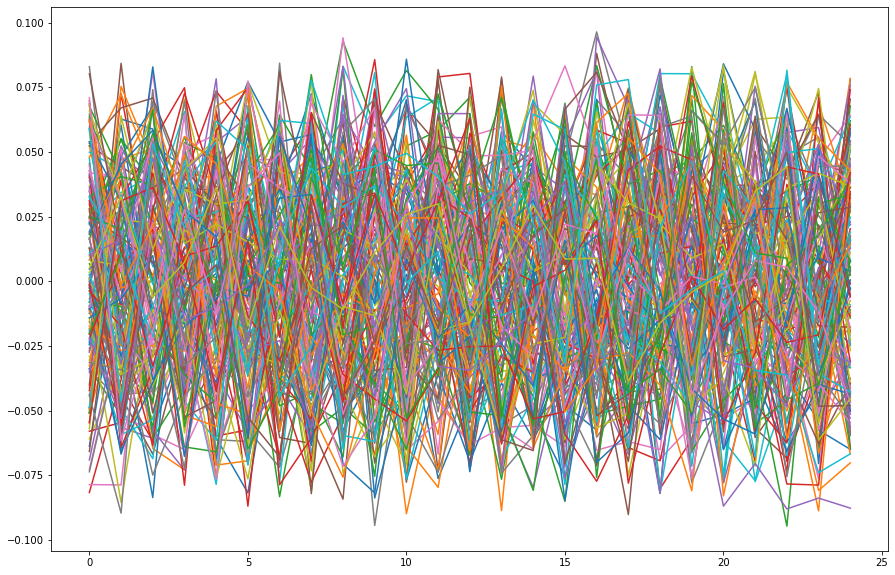

In [37]:
params = list(agent.model_t.parameters())
print("biases", params[1])
weights = params[0].detach().cpu().numpy()
for i in range(0, 64):    
    plt.plot(weights[i], label=str(i))
# plt.legend()

In [ ]:
perfect_agent = PerfectAgent(config)

In [ ]:
tst_metrics = test(perfect_agent, env, preprocessor, verbose=True)
print(tst_metrics.keys())
fig, ax = plot_test_metrics(tst_metrics)


In [ ]:
perfect_agent.get_qvals(preprocessor.current_data()).shape

In [ ]:
preprocessor.current_data().price.shape